# Day 36 · MLP神经网络的训练

pytorch和cuda的安装有很多教程，这里就不多赘述了。

In [14]:
import torch
torch.cuda

<module 'torch.cuda' from '/home/ubuntu24/anaconda3/envs/torch-gpu/lib/python3.13/site-packages/torch/cuda/__init__.py'>

In [15]:
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    print("CUDA可用！")
    # 获取可用的CUDA设备数量
    device_count = torch.cuda.device_count()
    print(f"可用的CUDA设备数量: {device_count}")
    # 获取当前使用的CUDA设备索引
    current_device = torch.cuda.current_device()
    print(f"当前使用的CUDA设备索引: {current_device}")
    # 获取当前CUDA设备的名称
    device_name = torch.cuda.get_device_name(current_device)
    print(f"当前CUDA设备的名称: {device_name}")
    # 获取CUDA版本
    cuda_version = torch.version.cuda
    print(f"CUDA版本: {cuda_version}")
else:
    print("CUDA不可用。")

CUDA可用！
可用的CUDA设备数量: 1
当前使用的CUDA设备索引: 0
当前CUDA设备的名称: NVIDIA GeForce RTX 4070 Laptop GPU
CUDA版本: 12.4


## 数据的准备

In [16]:
# 导入3分类的鸢尾花数据集
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

iris=load_iris()
X=iris.data
y=iris.target
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(120, 4)
(120,)
(30, 4)
(30,)


In [17]:
# 神经网络对于输入数据敏感，因此要对输入的数据进行归一化处理
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [18]:
# 将数据转换为张量，Pytorch使用张量进行训练，张量可以理解为特殊的数组
X_train=torch.FloatTensor(X_train)
y_train=torch.LongTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.LongTensor(y_test)

## 模型设计

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定义MLP模型
model=nn.Sequential(
        nn.Linear(4,10),
        nn.ReLU(),
        nn.Linear(10,3)
)

# 或者
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(4, 10)  # 输入层到隐藏层
        self.relu = nn.ReLU() # 引入非线性
        self.fc2 = nn.Linear(10, 3)  # 隐藏层到输出层
# 输出层不需要激活函数，因为后面会用到交叉熵函数cross_entropy，交叉熵函数内部有softmax函数，会把输出转化为概率

    def forward(self,x):
        out=self.fc1(x)
        out=self.relu(out)
        out=self.fc2(out)
        return out

# MLP_model=MLP()

In [20]:
# 分类问题使用交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 使用Adam优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)


## 训练循环要点
采用交叉熵损失 + Adam 优化器。训练前先把模型和数据移动到同一设备，随后在循环中维护损失、准确率列表。


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

num_epochs = 20_000
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# 计算准确率
def calculate_accuracy(logits, labels):
    preds = torch.argmax(logits.detach(), dim=1)
    return (preds == labels).float().mean().item()

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train)
    train_loss.backward()
    optimizer.step()

    train_losses.append(train_loss.item())
    train_accuracies.append(calculate_accuracy(outputs, y_train))

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test)
        val_loss = criterion(val_outputs, y_test).item()
        val_acc = calculate_accuracy(val_outputs, y_test)

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    if epoch % 400 == 0:
        print(
            f'Epoch [{epoch}/{num_epochs}] '
            f'train_loss={train_loss.item():.4f} val_loss={val_loss:.4f} '
            f'train_acc={train_accuracies[-1]:.4f} val_acc={val_acc:.4f}'
        )


Epoch [400/20000] train_loss=0.0629 val_loss=0.0538 train_acc=0.9750 val_acc=0.9667
Epoch [800/20000] train_loss=0.0497 val_loss=0.0292 train_acc=0.9833 val_acc=1.0000
Epoch [1200/20000] train_loss=0.0473 val_loss=0.0203 train_acc=0.9833 val_acc=1.0000
Epoch [1600/20000] train_loss=0.0468 val_loss=0.0173 train_acc=0.9833 val_acc=1.0000
Epoch [2000/20000] train_loss=0.0467 val_loss=0.0161 train_acc=0.9833 val_acc=1.0000
Epoch [2400/20000] train_loss=0.0466 val_loss=0.0157 train_acc=0.9833 val_acc=1.0000
Epoch [2800/20000] train_loss=0.0466 val_loss=0.0156 train_acc=0.9833 val_acc=1.0000
Epoch [3200/20000] train_loss=0.0466 val_loss=0.0155 train_acc=0.9833 val_acc=1.0000
Epoch [3600/20000] train_loss=0.0466 val_loss=0.0153 train_acc=0.9833 val_acc=1.0000
Epoch [4000/20000] train_loss=0.0466 val_loss=0.0154 train_acc=0.9833 val_acc=1.0000
Epoch [4400/20000] train_loss=0.0466 val_loss=0.0153 train_acc=0.9833 val_acc=1.0000
Epoch [4800/20000] train_loss=0.0466 val_loss=0.0153 train_acc=0.98

## 可视化与收尾
有了损失/准确率数组，画双子图就能一眼看出模型是否过拟合或欠拟合。实践中建议在这里记录实验备注，比如 epoch 数、学习率、是否使用 GPU，方便未来对比。


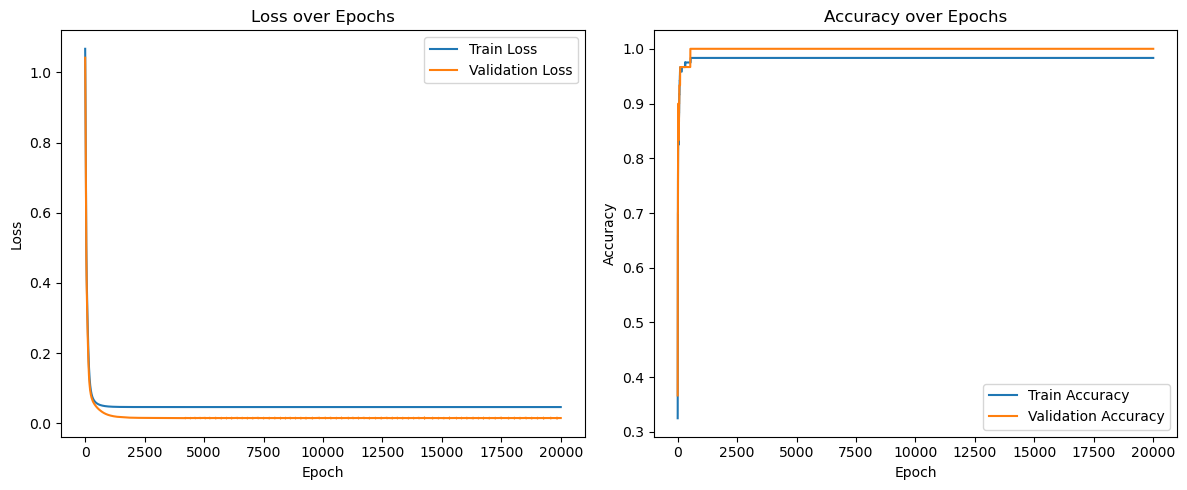

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()